# Adaptive LoRA for GLUE Benchmark
This notebook implements an Adaptive LoRA (Low-Rank Adaptation) strategy for fine-tuning transformers on the GLUE benchmark. The approach dynamically adjusts the active LoRA adapters during training based on entropy and gradient signals.

## Installation
Installing the necessary libraries: `transformers`, `datasets`, `evaluate`, `peft`, `accelerate`, and `tqdm`.

In [1]:
!pip install -q --upgrade "transformers>=4.36.0" "datasets" "evaluate" "peft>=0.6.0" "accelerate" "tqdm"
print("Install complete.")

Install complete.


## Imports and Setup
Importing standard libraries and Deep Learning frameworks (PyTorch, Hugging Face Transformers). We also define the computation device (CUDA/CPU) and a seeding function for reproducibility.

In [2]:
import os, math, time, random, json
from collections import defaultdict, OrderedDict, deque
from typing import Dict, Any, List, Tuple

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    get_scheduler
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model

import evaluate

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    print("Seed set to", seed)


Device: cuda


## Data Loading and Tokenization
We use the Hugging Face `datasets` library to load GLUE tasks.

The function `load_and_tokenize_glue` handles:
1.  Loading the raw dataset.
2.  Initializing the tokenizer.
3.  Tokenizing the input text fields appropriate for the specific GLUE task (e.g., single sentence vs. sentence pairs).

In [3]:
TASK_TO_KEYS = {
    'rte': ('sentence1', 'sentence2'),
    'sst2': ('sentence', None),
    'qnli': ('question', 'sentence'),
    'mrpc': ('sentence1', 'sentence2'),
    'mnli': ('premise', 'hypothesis'),
    'stsb': ('sentence1', 'sentence2'),
}

def get_num_labels_from_raw(raw_dataset):
    """Extract the number of labels from a raw GLUE dataset."""
    try:
        feat = raw_dataset['train'].features['label']
        if hasattr(feat, "num_classes"):
            return int(feat.num_classes)
    except Exception:
        pass
    labels = raw_dataset['train']['label']
    return int(max(labels)) + 1

def load_and_tokenize_glue(task_name: str, model_checkpoint: str, max_length: int = 128):
    print(f"Loading GLUE task '{task_name}' and tokenizer '{model_checkpoint}'")
    raw = load_dataset("glue", task_name)
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
    key1, key2 = TASK_TO_KEYS[task_name]

    def tokenize_batch(examples):
        if key2 is None:
            enc = tokenizer(examples[key1], truncation=True, padding="max_length", max_length=max_length)
        else:
            enc = tokenizer(examples[key1], examples[key2], truncation=True, padding="max_length", max_length=max_length)
        enc["labels"] = examples["label"]  # ensure labels column exists
        return enc

    remove_cols = raw["train"].column_names
    tokenized = raw.map(tokenize_batch, batched=True, remove_columns=remove_cols)
    cols = ["input_ids", "attention_mask", "labels"]
    if "token_type_ids" in tokenized["train"].column_names:
        cols.insert(1, "token_type_ids")
    tokenized.set_format(type="torch", columns=cols)
    num_labels = get_num_labels_from_raw(raw)
    print(f"Tokenized. Train size: {len(tokenized['train'])} Val size: {len(tokenized['validation'])} num_labels: {num_labels}")
    return raw, tokenized, tokenizer, num_labels

## Model Construction
Helper functions to load a pre-trained sequence classification model and apply LoRA (Low-Rank Adaptation) configuration using `peft`.

In [4]:
def get_target_modules_for_model(model_name: str) -> List[str]:
    # broad matching list for common transformer attention/proj components
    return ["q_lin", "k_lin", "v_lin", "out_lin", "query", "key", "value", "proj", "dense", "linear"]

def build_model_with_lora(model_checkpoint: str, num_labels: int, lora_cfg: Dict[str, Any]):
    print(f"Loading base model {model_checkpoint} and applying LoRA")
    base = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
    peft_cfg = LoraConfig(
        r=lora_cfg.get("r", 16),
        lora_alpha=lora_cfg.get("lora_alpha", 32),
        lora_dropout=lora_cfg.get("lora_dropout", 0.1),
        bias="none",
        task_type="SEQ_CLS",
        target_modules=get_target_modules_for_model(model_checkpoint)
    )
    model = get_peft_model(base, peft_cfg)
    model.to(DEVICE)
    try:
        model.print_trainable_parameters()
    except Exception:
        pass
    return model

## Adapter Importance Metrics
Functions to estimate the "importance" of LoRA adapters.

- `compute_adapter_importance_safe`: Calculates the norm of LoRA weights (A or B matrices).
- `entropy_of_distribution`: Calculates the Shannon entropy of a normalized distribution of importance scores.

In [5]:
def iter_named_lora_modules(model):
    """Yield (name, module) for modules that contain LoRA params (heuristic)."""
    for name, module in model.named_modules():
        # presence of lora_A or lora_B attributes is typical
        if hasattr(module, "lora_A") or hasattr(module, "lora_B"):
            yield name, module

def compute_adapter_importance_safe(name: str, module) -> float:
    """Proxy importance: use norm of lora_B or lora_A where present."""
    try:
        if hasattr(module, "lora_B"):
            lb = getattr(module, "lora_B")
            if isinstance(lb, torch.Tensor):
                return float(torch.norm(lb).cpu().item())
            if hasattr(lb, "weight"):
                return float(torch.norm(lb.weight).cpu().item())
        if hasattr(module, "lora_A"):
            la = getattr(module, "lora_A")
            if isinstance(la, torch.Tensor):
                return float(torch.norm(la).cpu().item())
            if hasattr(la, "weight"):
                return float(torch.norm(la.weight).cpu().item())
    except Exception:
        pass
    return 0.0

def entropy_of_distribution(d: Dict[str, float]) -> float:
    """Shannon entropy of normalized distribution (in nats)."""
    vals = np.array(list(d.values()), dtype=float)
    s = np.sum(vals)
    if s == 0:
        return 0.0
    p = vals / s
    # avoid log(0)
    p = p[p > 0]
    return float(-np.sum(p * np.log(p)))

## Adaptive LoRA Controller
The `AdaptiveLoRAControllerV3` class manages the dynamic selection of active LoRA layers during training.

**Key Mechanisms:**
- **Entropy-based Layer Selection**: Uses the entropy of importance scores to determine how many and which layers to activate.
- **Cosine Scheduling**: Smoothly varies hyperparameters (alpha, combine ratio) over epochs.
- **Gating**: Optional soft gating or hard freezing of adapters.

In [6]:
class AdaptiveLoRAControllerV3:
    """
    - Uses entropy-based layer selection
    - Uses cosine schedules for alpha (weight vs grad mix) and combine ratio
    - adaptations_per_epoch scheduling
    - optional gating (soft) or hard freeze
    """
    def __init__(
        self,
        model: nn.Module,
        train_dataloader: DataLoader,
        optimizer: torch.optim.Optimizer,
        adaptations_per_epoch: int = 5,
        importance_threshold: float = 0.85,
        min_layers: int = 2,
        cooldown_steps_between_toggles: int = 2,
        smoothing_alpha: float = 0.3,
        use_gating: bool = False,
        alpha_start: float = 0.5,
        alpha_end: float = 0.9,
        combine_start: float = 0.5,
        combine_end: float = 0.9,
        total_epochs: int = 5
    ):
        self.model = model
        self.train_dataloader = train_dataloader
        self.optimizer = optimizer

        self.steps_per_epoch = max(1, len(train_dataloader))
        self.adaptations_per_epoch = max(1, adaptations_per_epoch)
        self.adaptation_interval = max(1, self.steps_per_epoch // self.adaptations_per_epoch)

        self.importance_threshold = importance_threshold
        self.min_layers = min_layers
        self.cooldown = cooldown_steps_between_toggles
        self.smoothing_alpha = smoothing_alpha
        self.use_gating = use_gating

        # schedule params
        self.alpha_start = alpha_start
        self.alpha_end = alpha_end
        self.combine_start = combine_start
        self.combine_end = combine_end
        self.total_epochs = max(1, total_epochs)

        self.step = 0
        self.epoch = 0
        self.adapter_weight_acc = defaultdict(float)
        self.gradient_acc = {}  # param_id -> [sum_sq, cnt]
        self.smoothed_scores = {}
        self.last_toggled = defaultdict(lambda: -999999)
        self.freezing_log = []

        # adapters discovery
        self.adapters = OrderedDict()
        self.param_to_adapter = {}
        self._discover_adapters()

        if self.use_gating:
            self._init_gates()

    def _discover_adapters(self):
        for name, module in iter_named_lora_modules(self.model):
            self.adapters[name] = module
            for p in module.parameters():
                self.param_to_adapter[id(p)] = name

    def _init_gates(self):
        self.gates = nn.ParameterDict()
        for name in self.adapters:
            key = name.replace(".", "_")
            self.gates[key] = nn.Parameter(torch.tensor(1.0, device=next(self.model.parameters()).device))

    def compute_initial_importance(self, num_batches: int = 20):
        """Warm-start: forward a few batches, accumulate adapter norms as proxy."""
        self.adapter_weight_acc.clear()
        device = next(self.model.parameters()).device
        it = iter(self.train_dataloader)
        for i in range(num_batches):
            try:
                batch = next(it)
            except StopIteration:
                break
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                _ = self.model(**batch)
            for name, module in self.adapters.items():
                self.adapter_weight_acc[name] += compute_adapter_importance_safe(name, module)
        total = sum(self.adapter_weight_acc.values()) + 1e-12
        for k, v in self.adapter_weight_acc.items():
            self.smoothed_scores[k] = v / total if total > 0 else 0.0

    def accumulate_gradients(self):
        """Call after loss.backward(). Accumulate grad norms per param, mapped to adapters."""
        for p in self.model.parameters():
            if p.grad is None:
                continue
            pid = id(p)
            if pid not in self.param_to_adapter:
                continue
            gnorm = float(torch.norm(p.grad.detach(), p=2).cpu().item())
            if pid not in self.gradient_acc:
                self.gradient_acc[pid] = [0.0, 0]
            self.gradient_acc[pid][0] += gnorm ** 2
            self.gradient_acc[pid][1] += 1

    def _cosine_scheduler(self, step_or_epoch: float, total: float, start: float, end: float) -> float:
        """Cosine schedule from start -> end over total (step_or_epoch in [0,total])."""
        if total <= 1:
            return end
        x = min(max(step_or_epoch / total, 0.0), 1.0)
        cosv = 0.5 * (1 + math.cos(math.pi * (1 - x)))  # cosine ramp (0->1)
        return start * (1 - cosv) + end * cosv

    def _compute_combined_scores(self):
        """Combine weight (smoothed) + grad signals with dynamically scheduled mixing."""
        # aggregate param grads to adapter-level
        adapter_grad_sum = defaultdict(float)
        adapter_grad_cnt = defaultdict(int)
        for pid, (sum_sq, cnt) in self.gradient_acc.items():
            adapter_name = self.param_to_adapter.get(pid)
            if adapter_name is None: continue
            adapter_grad_sum[adapter_name] += sum_sq
            adapter_grad_cnt[adapter_name] += cnt

        # compute grad_score per adapter
        grad_scores = {}
        for name in self.adapters.keys():
            if adapter_grad_cnt[name] > 0:
                avg_grad = math.sqrt(adapter_grad_sum[name] / (adapter_grad_cnt[name] + 1e-12))
                grad_scores[name] = math.log1p(avg_grad)
            else:
                grad_scores[name] = 0.0

        # schedule alpha and combine_ratio using epoch progress
        alpha = self._cosine_scheduler(self.epoch, self.total_epochs, self.alpha_start, self.alpha_end)
        combine_ratio = self._cosine_scheduler(self.epoch, self.total_epochs, self.combine_start, self.combine_end)
        # weight_score = smoothed_scores (structure); grad_score = grad_scores
        raw = {}
        for name in self.adapters.keys():
            weight_score = self.smoothed_scores.get(name, 0.0)
            gs = grad_scores.get(name, 0.0)
            # first blend weight vs grad with alpha (alpha = weight weight, 1-alpha = grad)
            blended = alpha * weight_score + (1 - alpha) * gs
            # then apply combine_ratio (another blending stage if desired)
            raw[name] = combine_ratio * blended + (1 - combine_ratio) * weight_score

        # normalize raw -> probabilities
        tot = sum(raw.values()) + 1e-12
        normalized = {k: v / tot for k, v in raw.items()}

        # smoothing w/ previous smoothed_scores
        new_smoothed = {}
        for k, v in normalized.items():
            prev = self.smoothed_scores.get(k, v)
            new_smoothed[k] = self.smoothing_alpha * v + (1 - self.smoothing_alpha) * prev
        # final normalization
        s_tot = sum(new_smoothed.values()) + 1e-12
        return {k: v / s_tot for k, v in new_smoothed.items()}, alpha, combine_ratio

    def _select_active_entropy(self, scores: Dict[str, float]):
        """Entropy-aware selection: when entropy high, allow more active layers."""
        # sorted descending
        items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        # dynamic multiplier from entropy
        H = entropy_of_distribution(scores)
        # normalize entropy to [0,1] heuristically by log(K)
        K = max(1, len(scores))
        max_H = math.log(K + 1e-12)
        entropy_factor = H / (max_H + 1e-12)  # 0..1
        # base target cumulative threshold can be tightened or loosened by entropy_factor
        eff_threshold = self.importance_threshold * (0.5 + 0.5 * entropy_factor)  # if entropy high -> threshold closer to original or larger
        active = set()
        cum = 0.0
        for k, v in items:
            active.add(k)
            cum += v
            if cum >= eff_threshold:
                break
        # ensure minimum
        i = 0
        while len(active) < self.min_layers and i < len(items):
            active.add(items[i][0]); i += 1
        return active, H, eff_threshold

    def _refresh_optimizer(self):
        """Rebuild optimizer to reflect newly trainable params."""
        try:
            params = [p for p in self.model.parameters() if p.requires_grad]
            OptimCls = type(self.optimizer)
            new_optim = OptimCls(params, **self.optimizer.defaults)
            try:
                new_optim.load_state_dict(self.optimizer.state_dict())
            except Exception:
                pass
            self.optimizer = new_optim
        except Exception:
            pass

    def maybe_adapt(self):
        """Call each training step; performs adaptation when it's time."""
        self.step += 1
        if (self.step % self.adaptation_interval) != 0:
            return False
        # compute combined scores using current epoch
        combined_scores, alpha, combine_ratio = self._compute_combined_scores()
        if not combined_scores:
            return False
        # select active set using entropy-aware method
        active, entropy_val, effective_threshold = self._select_active_entropy(combined_scores)
        changed = False
        now = self.step
        for name, module in self.adapters.items():
            if (now - self.last_toggled[name]) < self.cooldown:
                continue
            should_active = (name in active)
            currently_active = any(p.requires_grad for p in module.parameters())
            if self.use_gating:
                key = name.replace(".", "_"); gate = self.gates[key]
                new_val = 1.0 if should_active else 0.0
                if float(gate.data) != new_val:
                    gate.data = torch.tensor(new_val, device=gate.device); changed = True
            else:
                if should_active and not currently_active:
                    for p in module.parameters(): p.requires_grad = True
                    changed = True; self.last_toggled[name] = now
                elif (not should_active) and currently_active:
                    for p in module.parameters(): p.requires_grad = False
                    changed = True; self.last_toggled[name] = now
        if changed and not self.use_gating:
            self._refresh_optimizer()
        # log
        active_norms = [combined_scores[n] for n in active] if active else []
        threshold_used = min(active_norms) if active_norms else 0.0
        self.freezing_log.append({
            "step": self.step,
            "epoch": self.epoch,
            "alpha": alpha,
            "combine_ratio": combine_ratio,
            "entropy": entropy_val,
            "effective_threshold": effective_threshold,
            "threshold": threshold_used,
            "active": list(active),
            "sample_scores": dict(list(combined_scores.items())[:20]),
            "trainable_params": sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        })
        # reset gradient accumulator
        self.gradient_acc.clear()
        # update smoothed scores
        self.smoothed_scores.update(combined_scores)
        return changed

    def set_epoch(self, epoch_idx: int):
        self.epoch = epoch_idx
        # optionally decay smoothing or other hyperparams per epoch here

## Training and Evaluation Loop
Functions to execute the training process using the Adaptive Controller.
- `evaluate_model`: Runs the model on the validation set.
- `train_adaptive_v3`: Sets up the optimizer, scheduler, and controller, then runs the training loop, periodically calling `controller.maybe_adapt()`.

In [7]:
def evaluate_model(model, dataloader):
    model.eval()
    preds, refs = [], []
    for batch in dataloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        with torch.no_grad():
            out = model(**batch)
        logits = out.logits
        p = torch.argmax(logits, dim=-1).cpu().tolist()
        r = batch["labels"].cpu().tolist()
        preds.extend(p); refs.extend(r)
    return evaluate.load("accuracy").compute(predictions=preds, references=refs)

def train_adaptive_v3(cfg, tokenized, tokenizer):
    # dataloaders
    train_loader = DataLoader(tokenized["train"], batch_size=cfg["batch_size"], shuffle=True,
                              collate_fn=DataCollatorWithPadding(tokenizer))
    val_loader = DataLoader(tokenized["validation"], batch_size=cfg["batch_size"], shuffle=False,
                            collate_fn=DataCollatorWithPadding(tokenizer))

    # model + LoRA
    model = build_model_with_lora(cfg["model"], cfg["num_labels"], cfg["lora_config"])
    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg["lr"])

    # controller
    controller = AdaptiveLoRAControllerV3(
        model=model,
        train_dataloader=train_loader,
        optimizer=optimizer,
        adaptations_per_epoch=cfg.get("adaptations_per_epoch", 5),
        importance_threshold=cfg.get("importance_threshold", 0.85),
        min_layers=cfg.get("min_layers", 2),
        cooldown_steps_between_toggles=cfg.get("cooldown", 2),
        smoothing_alpha=cfg.get("smoothing_alpha", 0.3),
        use_gating=cfg.get("use_gating", False),
        alpha_start=cfg.get("alpha_start", 0.5),
        alpha_end=cfg.get("alpha_end", 0.9),
        combine_start=cfg.get("combine_start", 0.5),
        combine_end=cfg.get("combine_end", 0.9),
        total_epochs=cfg["epochs"]
    )

    if cfg.get("compute_initial_importance", True):
        controller.compute_initial_importance(num_batches=min(10, len(train_loader)))

    total_steps = cfg["epochs"] * len(train_loader)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    results = []
    freezing_log = []

    for epoch in range(cfg["epochs"]):
        set_seed(cfg.get("seed", 42))
        controller.set_epoch(epoch)
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg['epochs']}")
        for step, batch in enumerate(pbar):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            out = model(**batch)
            loss = out.loss
            loss.backward()
            controller.accumulate_gradients()
            changed = controller.maybe_adapt()
            if changed:
                freezing_log.extend(controller.freezing_log[-1:])
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            pbar.set_postfix(loss=loss.item())
        # eval
        acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1} accuracy:", acc)
        results.append({"epoch": epoch+1, "metrics": acc, "trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad)})
    return results, freezing_log

## Experiment Configuration
Defining the grid of hyperparameters and settings for experiments.

In [12]:
def build_experiment_grid(models=None, tasks=None):
    if models is None:
        models = ["distilbert-base-uncased"]
    if tasks is None:
        tasks = ["sst2"]  # quick test: choose 1-2 tasks
    LRS = [2e-5]
    LORA_CFGS = [{"r": 16, "lora_alpha": 32, "lora_dropout": 0.1}]
    ADAPT_CFGS = [{
        "adaptations_per_epoch": 8,
        "importance_threshold": 0.85,
        "min_layers": 2,
        "compute_initial_importance": True
    }]
    exps = []
    eid = 0
    for m in models:
        for t in tasks:
            for strategy in ["adaptive_v3"]:
                for lr in LRS:
                    for lcfg in LORA_CFGS:
                        cfg = {
                            "exp_id": f"grid_{eid:03d}",
                            "model": m,
                            "task": t,
                            "strategy": strategy,
                            "lr": lr,
                            "batch_size": 32,
                            "epochs": 2,
                            "seed": 42,
                            "lora_config": lcfg
                        }
                        cfg.update(ADAPT_CFGS[0])
                        exps.append(cfg)
                        eid += 1
    print("Total experiments:", len(exps))
    return exps


## Experiment Execution
Running the defined grid of experiments, saving results to CSV and JSON logs.

In [13]:
def run_grid(experiments, save_dir="./results_v3"):
    os.makedirs(save_dir, exist_ok=True)
    master = []
    for cfg in experiments:
        print("\n=== Running", cfg["exp_id"], cfg["strategy"], cfg["model"], "===")
        set_seed(cfg["seed"])
        try:
            raw, tokenized, tokenizer, num_labels = load_and_tokenize_glue(cfg["task"], cfg["model"], max_length=128)
            cfg["num_labels"] = num_labels
            res, log = train_adaptive_v3(cfg, tokenized, tokenizer)
            master.extend([dict(cfg, **r) for r in res])
            pd.json_normalize(res).to_csv(os.path.join(save_dir, f"{cfg['exp_id']}_results.csv"), index=False)
            with open(os.path.join(save_dir, f"{cfg['exp_id']}_freezing.json"), "w") as f:
                json.dump(log, f, indent=2)
            print("Saved results for", cfg["exp_id"])
        except Exception as e:
            print("⚠️ Experiment failed:", e)
    if master:
        pd.json_normalize(master).to_csv(os.path.join(save_dir, "master_results.csv"), index=False)
    return master

## Quick Sanity Check
Running a small-scale experiment (1 task, 1 model) to verify that the pipeline works correctly.

In [14]:
grid = build_experiment_grid(models=["distilbert-base-uncased"], tasks=["sst2"])
print("Grid:", grid)
master_results = run_grid(grid, save_dir="./results_v3")
print("Done. experiments:", len(master_results))

Total experiments: 1
Grid: [{'exp_id': 'grid_000', 'model': 'distilbert-base-uncased', 'task': 'sst2', 'strategy': 'adaptive_v3', 'lr': 2e-05, 'batch_size': 32, 'epochs': 2, 'seed': 42, 'lora_config': {'r': 16, 'lora_alpha': 32, 'lora_dropout': 0.1}, 'adaptations_per_epoch': 8, 'importance_threshold': 0.85, 'min_layers': 2, 'compute_initial_importance': True}]

=== Running grid_000 adaptive_v3 distilbert-base-uncased ===
Seed set to 42
Loading GLUE task 'sst2' and tokenizer 'distilbert-base-uncased'


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Tokenized. Train size: 67349 Val size: 872 num_labels: 2
Loading base model distilbert-base-uncased and applying LoRA


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,181,954 || all params: 68,136,964 || trainable%: 1.7347
Seed set to 42


Epoch 1/2:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 1 accuracy: {'accuracy': 0.841743119266055}
Seed set to 42


Epoch 2/2:   0%|          | 0/2105 [00:00<?, ?it/s]

Epoch 2 accuracy: {'accuracy': 0.8520642201834863}
Saved results for grid_000
Done. experiments: 2


## Visualization
Plotting the number of trainable parameters over time.

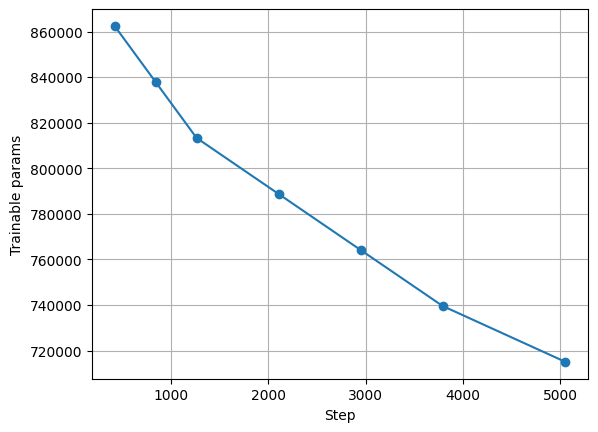

In [11]:
import matplotlib.pyplot as plt

def plot_trainable_params_from_log(logfile):
    with open(logfile, 'r') as f:
        data = json.load(f)
    steps = [e['step'] for e in data]
    tp = [e['trainable_params'] for e in data]
    plt.plot(steps, tp, marker='o')
    plt.xlabel("Step"); plt.ylabel("Trainable params"); plt.grid(True)

# Example usage:
plot_trainable_params_from_log("./results_v3/grid_000_freezing.json")